# YANK Simulation Health Report

General Settings
========

Mandatory Settings
----------------
* `store_directory`: Location where the experiment was run. This has an `analysis.yaml` file and two `.nc` files.

Optional Settings
----------------
* `decorrelation_threshold`: When number of decorrelated samples is less than this percent of the total number of samples, raise a warning. Default: `0.1`.
* `mixing_cutoff`: Minimal level of mixing percent from state `i` to `j` that will be plotted. Default: `0.05`.
* `mixing_warning_threshold`: Level of mixing where transition from state `i` to `j` generates a warning based on percent of total swaps. Default: `0.90`.
* `phase_stacked_replica_plots`: Boolean to set if the two phases' replica mixing plots should be stacked one on top of the other or side by side. If `True`, every replica will span the whole notebook, but the notebook will be longer. If `False`, the two phases' plots will be next to each other for a shorter notebook, but a more compressed view. Default `False`.

In [1]:
# Mandatory Settings
store_directory = '/data/chodera/zhangi/perses_benchmark/repex/31/28/0/'
analyzer_kwargs = {}

# Optional Settings
decorrelation_threshold = 0.1
mixing_cutoff = 0.05
mixing_warning_threshold = 0.90
phase_stacked_replica_plots = False

## Data Imports

These are the imports and files which will be referenced for the report

In [2]:
from matplotlib import pyplot as plt
from yank.reports import notebook
%matplotlib inline
report = notebook.HealthReportData(store_directory, **analyzer_kwargs)
report.report_version()

/home/zhangi/miniconda3/envs/perses-rbd-ace2/lib/python3.8/site-packages/yank/analyze.py:299: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  analysis = yaml.load(f)


Rendered with YANK Version 0.25.2


## General Simulation Data:

Reports the number of iterations, states, and atoms in each phase. If no checkpoint file is found, the number of atoms is reported as `No Cpt.` as this information is inferred from the checkpoint file. All other information comes from the analysis file.

In [3]:
report.general_simulation_data()

   Phase   | Iterations | Replicas | States | Num Atoms 
 0_complex |    7965    |    24    |   24   |  183593   
--------------------------------------------------------


Equilibration
=============

How to interpret these plots
--------------------------
Shown is the potential energy added up across all replicas (black dots), the moving average (red line), and where we have auto-detected the equilibration (blue line) for each phase. Finally, the total number of decorrelated samples for each phase is attached to each plot.

You want to see a majority of samples to the right of the blue line and the red line converging to a constant value.  If you do not see these trends or you think there are insufficient samples, please consider running for longer. 

For additional information on the theory of these charts, please see the Equilibration Primer at the Appendix of the report

See Something Odd?
-----------------

* **The scatter plot Y scale looks large and the equilibrium line is at Iteration 0**

This normally happens when the energy from index 0 comes from the energy minimized configuration. Because this configuration is technically not from the equilibrium distribution, it can have large energies far from the true mean equilibrium energy. This can cause the ``detectEquilibration`` algorithm we use to think that the jump in energy from the minimized to the equilibrated is the scale of the energy fluctuations, and therefore all other fluctuations appear as though they are equilibrated. Look close at the first few points: is there are there a few points which are a large shift on the first few steps? If so, consider removing those first few points from the timeseries.

*Solution:* Increase ``discard_from_start``

*Warning:* Some simulations (frequently solvent simulations) are often equilibrated *starting* at iteration 0. These simulations are usually scattered over the entire height of the figure. You should only consider discarding samples if the samples are not distributed over the height of the figure. 

Options
-------
* ``discard_from_start``: Integer. Number of samples to discard from the start of the data. This is helpful for simulations where the minimized energy configuration throws off the equilibration detection.

In [4]:
sams_weights_figure = report.generate_sams_weights_plots()

No SAMS logZ history found.


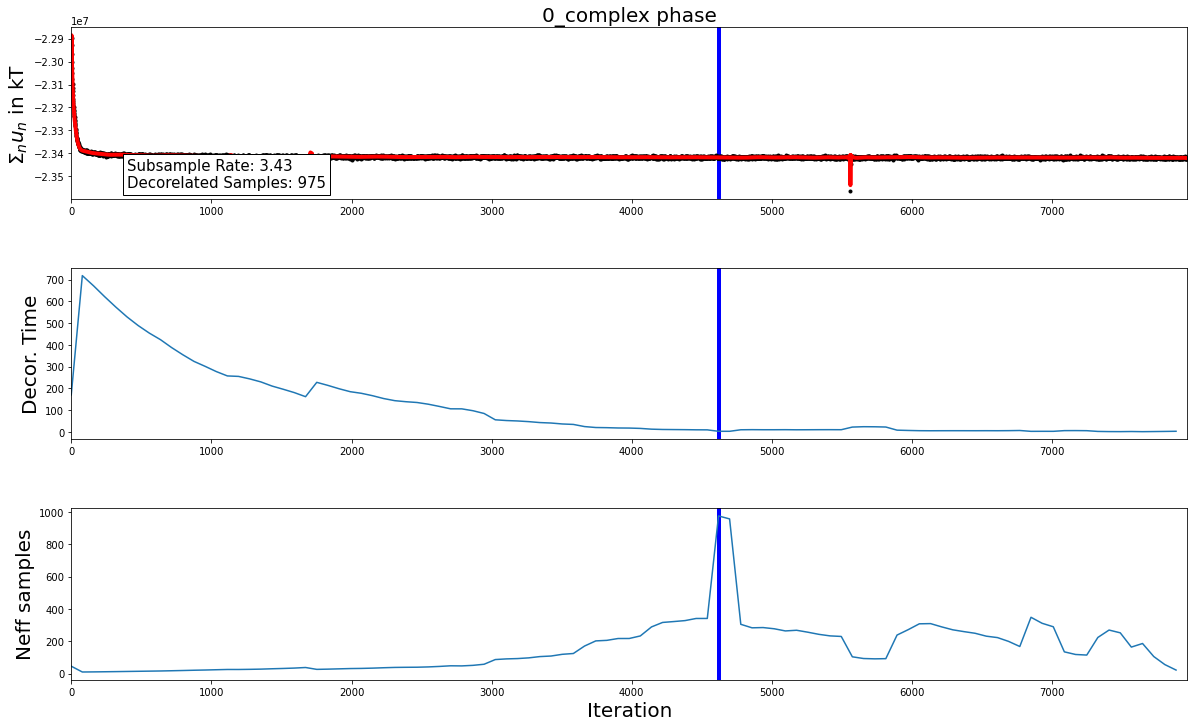

In [5]:
equilibration_figure = report.generate_equilibration_plots(discard_from_start=1)

Additional Decorrelation Analysis
==================

The following Pie Charts show you the breakdown of how many samples were kept, and how many were lost to either equilibration or decorrelation. Warnings are shown when below a threshold (originally written to be 10%)

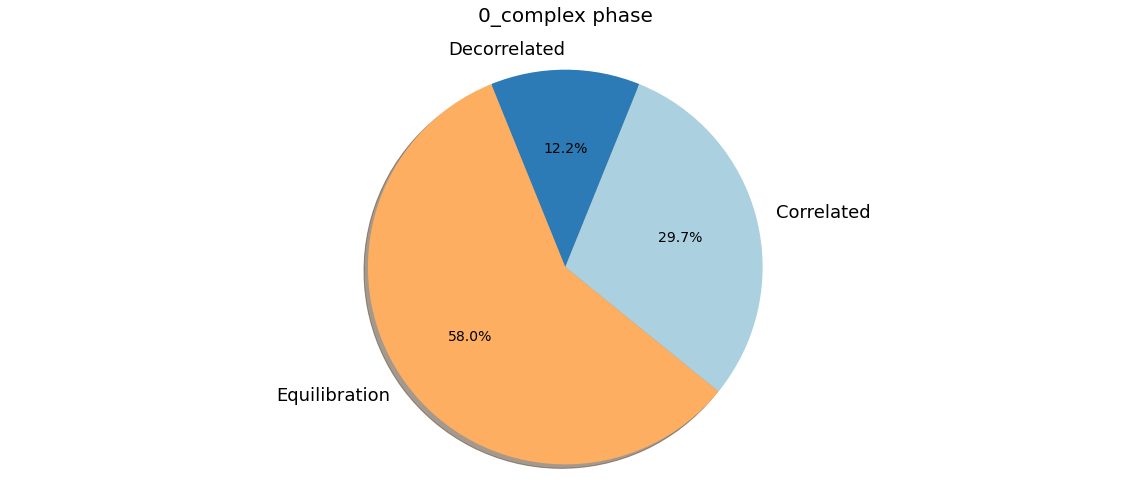

In [6]:
decorrelation_figure = report.generate_decorrelation_plots(decorrelation_threshold=0.1)

# RMSD Analysis

Trace the RMSD from the initial frame to the end of the simulaton for both the ligand and receptor.

This is an experimental feature and has been commented out due to instability

In [7]:
#rmsd_figure = report.compute_rmsds()

Mixing statistics
=================

We can analyze the "mixing statistics" of the equilibrated part of the simulation to ensure that the $(X,S)$ chain is mixing reasonably well among the various alchemical states.

For information on how this is computed, including how to interpret the Perron Eigenvalue, please see the *Mixing Statistics Primer* at the end of the report.


What do you want to see?
-----------------------
You want a replica to mix into other replicas, so you want a diffusion of configurations shown by a spread out color map in the figure. What you don't want to see is highly concentrated replicas that do not mix at all. The graphs will show red and generate a warning if there are replicas that do not mix well.

For the Perron/subdominant eigenvalue, you want to see a value smaller than one `1`. The further away, the better. This number gives you an estimate of how many iterations it will take to equilibrate the current data. Keep in mind that this analysis only runs on the *already equilibrated data* and is therefor an estimate of how long it takes the system to relax in state and configuration space from this point.


Seeing something odd?
--------------------
* **The diagonal is very dark, but everything else is white**

You probably have poor mixing between states. This happens when there is insufficient phase space overlap between states and the probability of two replicas at different states swapping configurations approaches zero. If you have set the `mixing_warning_cutoff`, many of these states will be highlighted as warnings.

*Solution*: Add additional states to your simulation near the states which are not mixing well. Provide a more gradual change of energy from the state to improve replica exchange from that state.

* **Graph is mostly white!**

This can happen if you have _too_ good of mixing alongside too many states. In this case, mixing between all states is happening so regularly that there is no concentration of configurations in one state.

*Solution*: Reduce `mixing_cutoff`.

* **Its still way too white**

That is a limitation of the custom colormap. You can try un-commenting the line `cmap = plt.get_cmap("Blues")` below to get a blue-scale colormap which has a far smaller white level so you can better see the diffusion in blue. You will lose the red warning color of states with too low a swap rate, but you can always comment the line back out to see those. The warning message will still be generated.

*Solution*: Override the custom colormap that the function uses by setting `cmap_override="Blues"` or any other registered `matplotlib` colormap name.

Options
-------
You can adjust the `mixing_cutoff` options to control what threshold to display mixing. Anything below the cutoff will be shown as a blank. Defaults to `0.05`. Accepts either a float from `[0,1]` or `None` (`None` and `0` yield the same result)

The `mixing_warning_threshold` is the level at which you determine there were insufficient number of swaps between states. Consider adding additional states between the warnings and adjacent states to improve mixing. Accepts a float between `(mixing_cutoff,1]` (must be larger than `mixing_cutoff`). Defaults to `0.9` but this should be tuned based on the number of states.

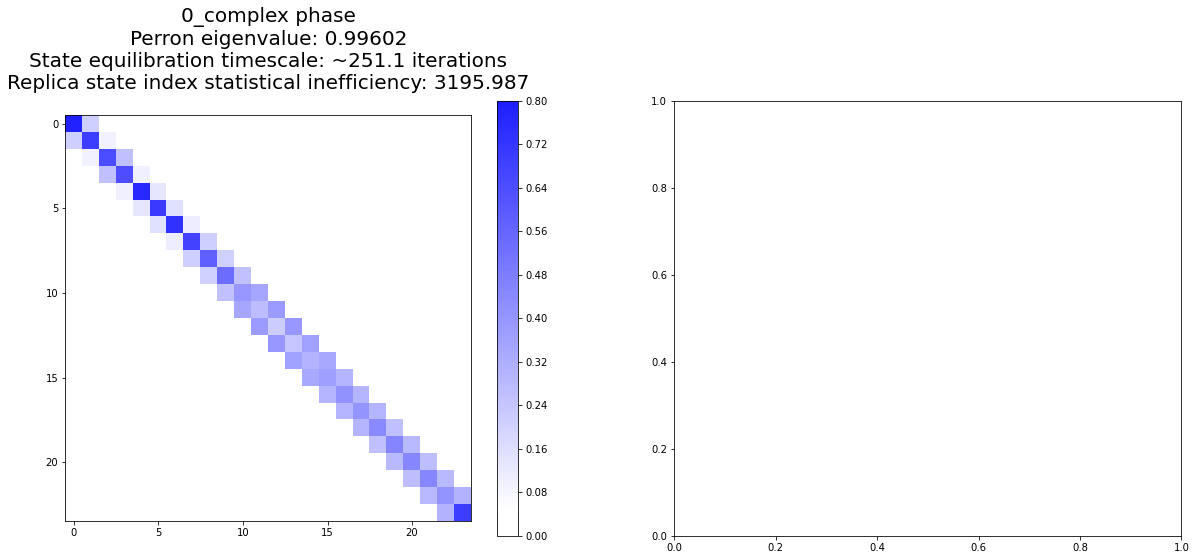

In [8]:
mixing_figure = report.generate_mixing_plot(mixing_cutoff=mixing_cutoff, 
                            mixing_warning_threshold=mixing_warning_threshold, 
                            cmap_override=None)

In [9]:
# Note: levi says this is called a tridiagonal matrix and is a result of using swap-neighbors (it would be more diffuse
# if we had used swap-all)

Replica Pseudorandom Walk Examination
====================

This section checks to see if all the replicas are exchanging states over the whole thermodynamic state space. This is different from tracking states as any replica is a continuous trajectory of configurations, just undergoing different forces at different times.

What do I want to see here?
-------------------------

Each plot is its own replica, the line in each plot shows which *state* a given replica is in at time. The ideal scenario is that all replicas visit all states numerous times. If you see a line that is relatively flat, then you can surmise that very little mixing is occurring from that replica and you may wish to consider adding more states around the stuck region to "un-stick" it.

Something seem odd?
------------------
* **All I see is black with some white dots mixed in (uncommon)**

This is a good thing! It means the replicas are well mixed and are rapidly changing states. There may be some phases which were redundant though, which is not necessarily a bad thing since it just adds more samples at the given state, but it may mean you did extra work. An example of this is *decoupling* the steric forces of a ligand once *electrostatics have been annihilated* in *implicit* solvent. Since there is no change to the intra-molecular interactions at this point and the most solvent models are based on partial charges (which are now 0), all changes to the sterics are the same state.

* **Some or All of my replicas stayed in the same state**

A sign of very poor mixing. Consider adding additional states (see the **Mixing Statistics** section above for ideas on where). There may be other factors such as a low number of attempted replica swaps between each iteration.


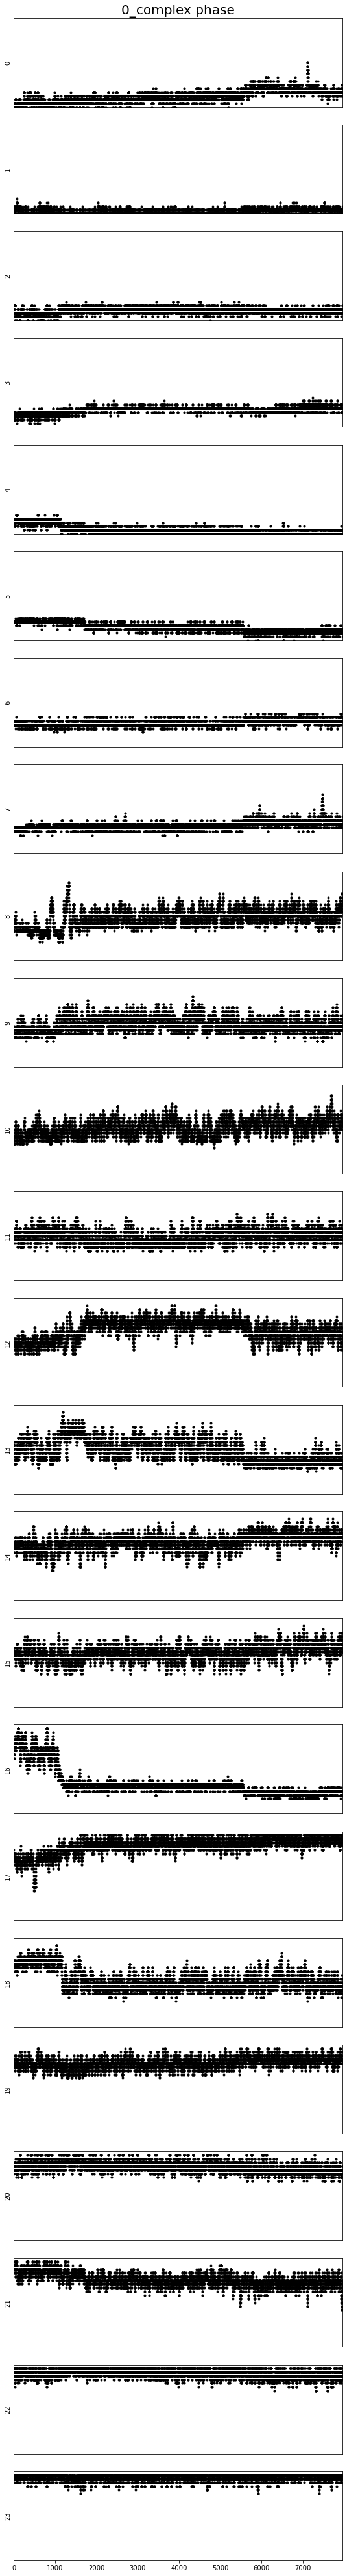

In [10]:
replica_mixing_figure = report.generate_replica_mixing_plot(phase_stacked_replica_plots=phase_stacked_replica_plots)

Free Energy Difference
============

The free energy difference is shown last as the quality of this estimate should be gauged with the earlier sections. Although MBAR provides an estimate of the free energy difference and its error, it is still only an estimate. You should consider if you have a sufficient number of decorrelated samples, sufficient mixing/phase space overlap between states, and sufficient replica random walk to gauge the quality of this estimate.

In [11]:
report.generate_free_energy()

KeyError: 'standard_state_correction'

# Free Energy Trace for Equilibrium Stability

The free energy difference alone, even with all the additional information previously, may still be an underestimate of the true free energy. One way to check this is to drop samples from the start and end of the simulation, and re-run the free energy estimate. Ideally, you would want to see the forward and reverse analysis be roughly converged for when more than 80% of the samples are kept, divergence when only 10-30% of the samples are kept is expected behavior. 

**Important**: The 100% kept samples free energy WILL be different than the free energy difference above. The data analyzed here is not subsampled as this is an equlibrium test only. This is also only for *sampled* states where as the free energy difference from above includes the unsampled states.

See Klimovich, Shirts, and Mobley (J Comput Aided Mol Des., 29(5) https://dx.doi.org/10.1007%2Fs10822-015-9840-9) for more information on this analysis

## What do I want to see here?

There are three plots: one for each phase, and the combination. You want the two traces to be on top of each other for at least some of the larger kept samples. The horizontal band is the 2 standard deviations of the free energy estimate when all 100% of the samples are kept and can be used as reference as the esimtate diverges at smaller numbers of kept samples. Error bars are shown as 2 standard deviations

In [ ]:
free_energy_trace_figure = report.free_energy_trace(discard_from_start=1, n_trace=10)

# Radially-symmetric restraint energy and distance distributions

This plot is generated only if the simulation employs a radially-symmetric restraint (e.g. harmonic, flat-bottom), and the unbias_restraint option of the analyzer was set.

## What do I want to see here?
When unbiasing the restraint, it is important to verify that the cutoffs do not remove too many configurations sampled from the bound state. Almost all the density of the bound state should be on the left of an eventual cutoff (red line).

In general, we expect the distribution in the bound state to be narrower than in the non-interacting state. If this is not the case, then either the binder is weak and it has left the binding site during the simulation, or the restraint might be too tight and limiting the conformational space explored by the ligand.

In [ ]:
restraint_distribution_figure = report.restraint_distributions_plot()

## Execute this block to write out serialized data

This is left commented out in the template to prevent it from auto-running with everything else


In [13]:
#report.dump_serial_data('SERIALOUTPUT')

----
Primers
====

Equilibration Primer
===========

Is equilibration necessary?
---------------------------

In principle, we don't need to discard initial "unequilibrated" data; the estimate over a very long trajectory will converge to the correct free energy estimate no matter what---we simply need to run long enough.  Some MCMC practitioners, like Geyer, feel strongly enough about this to throw up a webpage in defense of this position:

http://users.stat.umn.edu/~geyer/mcmc/burn.html

In practice, if the initial conditions are very atypical of equilibrium (which is often the case in molecular simulation), it helps a great deal to discard an initial part of the simulation to equilibration.  But how much?  How do we decide?

Determining equilibration in a replica-exchange simulation
----------------------------------------------------------

For a standard molecular dynamics simulation producing a trajectory $x_t$, it's reasonably straightforward to decide approximately how much to discard if human intervention is allowed.  We simply look at some property $A_t = A(x_t)$ over the course of the simulation---ideally, a property that we know has some slow behavior that may affect the quantities we are interested in computing ($A(x)$ is a good choice if we're interested in the expectation $<A>$) and find the point where $A_t$ seems to have "settled in" to typical equilibrium behavior.

If we're interested in a free energy, which is computed from the potential energy differences, let's suppose the potential energy $U(x)$ may be a good quantity to examine.

But in a replica-exchange simulation, there are K replicas that execute nonphysical walks on many potential energy functions $U_k(x)$.  What quantity do we look at here?

Let's work by analogy.  In a single simulation, we would plot some quantity related to the potential energy $U(x)$, or its reduced version $u(x) = \beta U(x)$.  This is actually the negative logarithm of the probability density $\pi(x)$ sampled, up to an additive constant:

$$\pi(x) = Z^{-1} e^{-u(x)}$$
$$u(x) = -\ln \pi(x) + c$$

For a replica-exchange simulation, the sampler state is given by the pair $(X,S)$, where $X = \{x_1, x_2, \ldots, x_K \}$ are the replica configurations and $S = \{s_1, s_2, \ldots, s_K\}$ is the vector of state index permutations associated with the replicas.  The total probability sampled is

$$\Pi(X,S) = \prod_{k=1}^K \pi_{s_k}(x_k) = (Z_1 \cdots Z_K) \exp\left[-\sum_{k=1}^K u_{s_k}(x_k)\right] = Q^{-1} e^{-u_*(X)}$$

where the pseudoenergy $u_*(X)$ for the replica-exchange simulation is defined as

$$u_*(X) \equiv \sum_{k=1}^K u_{s_k}(x_k)$$

That is, $u_*(X)$ is the sum of the reduced potential energies of each replica configuration at the current thermodynamic state it is visiting.

Mixing Statistics Primer
=============

How we compute the mixing ratios
------------------------------

In practice, this is done by recording the number of times a replica transitions from alchemical state $i$ to state $j$ in a single iteration.  Because the overall chain must obey detailed balance, we count each transition as contributing 0.5 counts toward the $i \rightarrow j$ direction and 0.5 toward the $j \rightarrow i$ direction.  This has the advantage of ensuring that the eigenvalues of the resulting transition matrix among alchemical states are purely real.

Interpreting the Perron (subdominant/second) Eigenvalue 
----------------------------------------------------

If the subdominant eigenvalue would have been unity, then the chain would be *decomposable*, meaning that it completely separated into two separate sets of alchemical states that did not mix.  This would have been an indication of poor phase space overlap between some alchemical states.

In practice, it's a great idea to monitor these statistics as the simulation is running, even if no data is discarded to equilibration at that point.  They give not only a good idea of whether sufficient mixing is occurring, but it provides a lower bound on the mixing time in configuration space.

If the configuration $x$ sampling is infinitely fast so that $x$ can be considered to be at equilibrium given the instantaneous permutation $S$ of alchemical state assignments, the subdominant eigenvalue $\lambda_2 \in [0,1]$ gives an estimate of the mixing time of the overall $(X,S)$ chain:
    
$$\tau = \frac{1}{1 - \lambda_2}$$

Now, in most cases, the configuration $x$ sampling is *not* infinitely fast, but at least we can use $\tau$ to get a very crude estimate of how quickly each replica relaxes in $(X,S)$ space.

Gelman-Rubin Convergence Primer
====================================

In 1992, Gelman and Rubin proposed a very clever idea for a convergence diagnostic in the case that multiple MCMC samplers are run from different initial sampler states:

http://dx.doi.org/10.1214/ss/1177011136

The idea is simple: Each chain gives an individual estimate for some computed expectation or property, and the whole collection of chains give a (presumably more precise) estimate.  We can simply compare the individual estimates to the overall estimate to determine whether the chains have been run long enough to see concordance between the individual and global estimates, to within appropriate statistical error.  If not, then the samplers have not yet run long enough to sample all of the important modes of the density.
    
We can apply a similar idea here, especially if we have initialized our replicas with different configurations (e.g. different docked ligand conformations, and potentially different protein conformations as well).

**Note**: This feature has not yet been added